In [1]:
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import muon as mu
import scirpy as ir
np.random.seed(42)
import random
random.seed(42)

2025-08-26 21:55:01.960353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 21:55:01.977855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756259701.995108 1860128 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756259702.000396 1860128 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756259702.013477 1860128 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## load mdata

In [2]:
mdata1 = mu.read('Tonly_CNS_DE2000.h5mu')
state_1 = pd.concat([mdata1['gex'].obs['state'], mdata1['airr'].obs['clone_id_size']], axis = 1)

mdata2 = mu.read('Tonly_SPL_DE2000.h5mu')
state_2 = pd.concat([mdata2['gex'].obs['state'], mdata2['airr'].obs['clone_id_size']], axis = 1)

df = pd.concat([state_1, state_2], axis= 0)
# df.to_csv('T_states.csv')

In [3]:
mdata = mu.read("/ix1/ylee/Yifan_Zhang/Code_data/data_EAE/anndata/all_Common_DEtop2000.h5mu")

In [4]:
common_obs = mdata1.obs_names.intersection(mdata.obs_names).to_list() + mdata2.obs_names.intersection(mdata.obs_names).to_list()
mdata = mdata[common_obs,:]
mdata

View of MuData object with n_obs × n_vars = 43562 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'mouse_BC'
  2 modalities
    gex:	43562 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'mouse_BC'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p'
    airr:	43562 x 0
      obsm:	'airr'

In [5]:
# exclude 2D2 transfer samples

selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325"]
selected_date = ["0516"]
selected_tissue = ["CN"]

mdata = mdata[~ (mdata['gex'].obs["mouse_BC"].isin(selected_samples_id) & mdata["gex"].obs["date"].isin(selected_date))]

meta_airr = ir.get.airr(mdata['airr'], ["cdr3_aa", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))

mdata.obs = mdata.obs.join(meta_airr)

mdata

MuData object with n_obs × n_vars = 43448 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'mouse_BC', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call'
  2 modalities
    gex:	43448 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'mouse_BC'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p'
    airr:	43448 x 0
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

## clonotype

In [6]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

# by nucleotide acid seq
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(mdata, min_cells=10)

# print("The num of clones is " + mdata['airr'].obs['clone_id'][-1])

In [7]:
# select cells appear in both CNS and SPL

# thresh on clono size
clone_thresh = 2
mdata.obs['cloned'] = mdata['airr'].obs['clone_id_size'] >= clone_thresh

# Check if appear in two tissues
mdata_cloned = mdata[mdata.obs['cloned']]
clone_tissue_df = mdata_cloned['airr'].obs[['clone_id']].join(mdata_cloned['gex'].obs['tissue'])
clone_tissue_counts = clone_tissue_df.groupby('clone_id')['tissue'].nunique()
multi_tissue_clones = clone_tissue_counts[clone_tissue_counts > 1].index
mdata.obs['in_two_tissue'] = mdata['airr'].obs['clone_id'].isin(multi_tissue_clones)


# Step 1: Extract clone_id and tissue info
# clone_tissue_df = mdata['airr'].obs[['clone_id']].join(mdata['gex'].obs['tissue'])
# # Step 2: Group by clone_id and count unique tissues
# clone_tissue_counts = clone_tissue_df.groupby('clone_id')['tissue'].nunique()
# # Step 3: Find clone_ids that appear in more than one tissue
# multi_tissue_clones = clone_tissue_counts[clone_tissue_counts > 1].index
# mdata.obs['in_two_tissue'] = mdata['airr'].obs['clone_id'].isin(multi_tissue_clones)

mdata.obs['in_two_tissue'].value_counts()

in_two_tissue
False    40456
True      2992
Name: count, dtype: int64

## TCR dist

In [8]:
from tcrdist.repertoire import TCRrep
# formating by tcrdist requirements
ref_df = pd.read_csv('data/TCRdist/std_MOG_assays.csv')
ref_df.rename(columns={'Chain 2 CDR3': 'cdr3_b_aa', 'Chain 2 V Gene':'v_b_gene', 
                   'Chain 2 J Gene':'j_b_gene', }, inplace=True)

ref_df['v_b_gene'] = ref_df['v_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')
ref_df['j_b_gene'] = ref_df['j_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')


In [9]:
mdata_subset = mdata[mdata.obs['cloned'] & ~mdata.obs['in_two_tissue']]
mdata_subset2 = mdata[mdata.obs['in_two_tissue']]
mdata_subset3 = mdata[~mdata.obs['cloned']]     

mdataSub_list = [mdata]

In [10]:
def mdata_TCR_formating(mdata_subset):
    query_df = mdata_subset.obs[['VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call']]
    query_df['cell_id'] = query_df.index
    query_df.dropna(subset = ["VDJ_1_cdr3_aa"])

    query_df.rename(columns={'VDJ_1_cdr3_aa': 'cdr3_b_aa', 'VDJ_1_v_call':'v_b_gene', 
                       'VDJ_1_j_call':'j_b_gene', }, inplace=True)

    # 'VDJ_1_consensus_count':'count'
    # query_df['cdr3_b_aa'] = 'C' + query_df['cdr3_b_aa'] + 'F'

    query_df['v_b_gene'] = query_df['v_b_gene'].str.split('+').str[0]
    query_df['j_b_gene'] = query_df['j_b_gene'].str.split('+').str[0]

    query_df['v_b_gene'] = query_df['v_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')
    query_df['j_b_gene'] = query_df['j_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')

    # query_df_clones = query_df_clones.drop(columns=["cell_id"])
    query_df_unique = query_df.drop_duplicates(['cdr3_b_aa'])
    return query_df_unique


In [11]:
def TCRdist_to_ref(ref_df, query_df_unique):
    tr_ref = TCRrep(cell_df = ref_df, 
                organism = 'mouse', 
                chains = ['beta'],
                compute_distances = False,)

    tr_q = TCRrep(cell_df = query_df_unique, 
                organism = 'mouse', 
                chains = ['beta'],
                compute_distances = False,)

    tr_ref.compute_rect_distances(tr_ref.clone_df,  tr_q.clone_df)
    print(tr_ref.rw_beta.shape)
    print(tr_ref.rw_beta)
    return tr_ref, tr_q


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

dist_thres = 85
tr_list = []
# for m_sub in mdataSub_list:

m_sub = mdata[mdata.obs['in_two_tissue']]
# m_sub = mdata

query_df = mdata_TCR_formating(m_sub)

tr_out, tr_query = TCRdist_to_ref(ref_df, query_df)
tr_list.append(tr_out)
flat_arr = tr_out.rw_beta.min(axis=0).flatten()
TCR_all = tr_query.clone_df
TCR_all['TCRdist_MOG'] = flat_arr

selected_clone_id = flat_arr < dist_thres
TCR_selected = TCR_all[selected_clone_id]
    
# # Example 2D array
# arr = tr.rw_beta.min(axis=0)

# # Flatten to 1D
# flat_arr = arr.flatten()

(25, 441)
[[121 107  68 ... 135 126 114]
 [118 128  80 ... 135 108 138]
 [118 113  92 ... 117 126 138]
 ...
 [121 107  68 ... 138 126 102]
 [121 107  68 ... 138 126 114]
 [118 101  56 ... 135 102 114]]


In [13]:
sub_2d2 = TCR_all[TCR_all['cdr3_b_aa']=='ASSLDCGANP']
sub_2d2

,cdr3_b_aa,v_b_gene,j_b_gene,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,count,clone_id,TCRdist_MOG


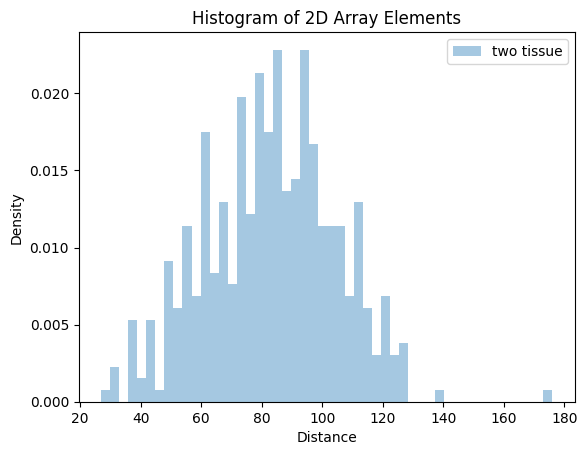

In [14]:
# Plot KDE (Kernel Density Estimate)
plt.hist(flat_arr, bins=50, density=True, alpha=0.4)
plt.legend(['two tissue', 'one tissue'])
plt.title("Histogram of 2D Array Elements")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

In [15]:
df2 = pd.read_csv('TCR_cloned_dist_2d2.csv')

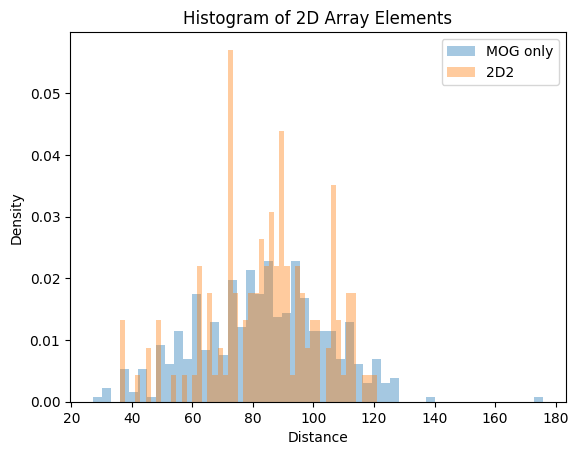

In [16]:
dist_2d2 = df2['TCRdist_MOG'].to_numpy()
plt.hist(flat_arr, bins=50, density=True, alpha=0.4)
plt.hist(dist_2d2, bins=50, density=True, alpha=0.4)
plt.legend(['MOG only', '2D2'])
plt.title("Histogram of 2D Array Elements")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

In [17]:
mdata_temp = mdata_subset2

my_dict = dict(zip(mdata_temp.obs['VDJ_1_cdr3_aa'], mdata_temp['airr'].obs['clone_id_size']))
# TCR_selected['cdr3_b_aa_trimed'] = TCR_selected['cdr3_b_aa'].str[1:-1]

# TCR_selected['clone_size'] = TCR_selected['cdr3_b_aa_trimed'].map(my_dict)
# TCR_selected

In [18]:
# TCR_all.to_csv('TCRdist_MOG.csv')

## DAE by chemokine

In [19]:
%cd /ihome/ylee/yiz133/Code/Data processing

/ihome/ylee/yiz133/Code/Data processing


In [20]:
## subset by TCR dist

mdata_temp = mdata
TCR_all['cdr3_b_aa_trimed'] = TCR_all['cdr3_b_aa'].str[1:-1].astype(str)

TCR_df = TCR_all[['cdr3_b_aa_trimed', 'TCRdist_MOG']]

mdata_temp = mdata_temp[mdata.obs['VDJ_1_cdr3_aa'].isin(TCR_all['cdr3_b_aa_trimed'])]
mdata_temp.obs['sc_BC'] = mdata_temp['gex'].obs.index

mdata_temp.obs = mdata_temp.obs.merge(TCR_df, how='left', left_on='VDJ_1_cdr3_aa', right_on='cdr3_b_aa_trimed')
mdata_temp.obs.set_index(mdata_temp.obs['sc_BC'], inplace=True)

mdata_temp


MuData object with n_obs × n_vars = 0 × 2000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'mouse_BC', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call', 'cloned', 'in_two_tissue', 'sc_BC', 'cdr3_b_aa_trimed', 'TCRdist_MOG'
  2 modalities
    gex:	0 x 2000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'mouse_BC'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p'
    airr:	0 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id', 'clonotype_network'
      obsm:	'airr', 'chain_indices', 'X_clonotype_network'

In [21]:
# mdata_subset = mdata
sc.pp.pca(mdata_temp["gex"], svd_solver="arpack", n_comps=10)
sc.pp.neighbors(mdata_temp["gex"], use_rep='X_pca', n_neighbors = 10)
sc.tl.umap(mdata_temp["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(mdata_temp["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata_temp["gex"], color=["tissue"])

ValueError: Found array with 0 sample(s) (shape=(0, 2000)) while a minimum of 1 is required.

In [ ]:
mdata_temp.obs['manual_cell_type'] = mdata_temp.obs['manual_cell_type'].cat.remove_unused_categories()
mu.pl.embedding(mdata_temp, basis="gex:umap", color= ['manual_cell_type', 'gex:mouse_id'], wspace = 0.2, ncols=2, vmin=0)

In [ ]:
chemokine_all = [g for g in mdata_temp["gex"].var_names if g.startswith(("Cc", "Cxc", "Cx3c"))]

# markers_in = []
# for i in chemokine:
#     if i in mdata_subset["gex"].var_names:
#         markers_in.append(i) 

In [ ]:
sc.tl.rank_genes_groups(mdata_temp["gex"], groupby ="tissue",  method="wilcoxon")
# mask_var = chemokine_all,

# sc.pl.rank_genes_groups_heatmap(mdata_subset["gex"], groupby = "tissue", gene_symbols= chemokine_all,
#                                  cmap='bwr',)

In [ ]:
# Get results as DataFrame
df = sc.get.rank_genes_groups_df(mdata_temp["gex"], group="CN")

# Filter to certain genes
df_filtered = df[df["names"].isin(chemokine_all)]

print(df_filtered)

In [ ]:
chemokine_topDE = df_filtered['names'].head(10)

mu.pl.embedding(mdata_temp, basis="gex:umap", color= chemokine_topDE[:4], ncols=2, vmin=0)

In [ ]:
expr_chemokine = mdata['gex'][:, chemokine_topDE.values].to_df()
expr_chemokine

In [ ]:
# expr_chemokine.to_csv('top10_chemok.csv')

In [ ]:
cellType_markers = ['Cd4', 'Cd8a','Cd8b1','Nkg7','Foxp3', 'Ikzf2', 'Ctla4', 'Il2ra','Ccr6', 'Il22']
cellState_markers = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Havcr2', 'Ccr7', 'Sell', 'Cd27']

markers_in = []
for i in cellType_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
markers_in
expr_markers = mdata['gex'][:, markers_in].to_df()
expr_markers.to_csv('marker_genes_for_training.csv')

In [ ]:
sc.pl.rank_genes_groups_dotplot(mdata_temp["gex"],  groupby="tissue", 
                                   var_names=chemokine_topDE[:10], cmap='Blues')


In [ ]:
vars_target_df = pd.read_csv('top10_chemok.csv')
sc.pl.rank_genes_groups_dotplot(mdata_temp["gex"],  groupby="tissue", 
                                   var_names=vars_target_df.columns[1:], cmap='Purples')    # 'Greens', 'Reds', 'Purples'


## DAE by MOG dist

In [ ]:
# merge df col to mdata obs
mdata.obs['sc_BC'] = mdata.obs.index
mdata.obs['TCRdist_short'] = True
mdata_DF = mdata.obs[['VDJ_1_cdr3_aa', 'TCRdist_short']]
mdata_DF.dropna(inplace=True)
mdata_DF.set_index('VDJ_1_cdr3_aa', inplace=True)

TCR_all['cdr3_b_aa_trimed'] = TCR_all['cdr3_b_aa'].str[1:-1]
merged_obs = mdata_DF.merge(TCR_all, how='left', left_on='VDJ_1_cdr3_aa', right_on='cdr3_b_aa_trimed')

mdata_DF

In [ ]:
mdata.obs['VDJ_1_cdr3_aa']

## GIANA embedings

In [ ]:
%cd /ihome/ylee/yiz133/Code/deepTCR/GIANA_output/

In [ ]:
# Create a sample 2D matrix
matrix = pd.read_csv('cdr3_id--RotationEncodingBL62.txt_EncodingMatrix.txt', sep = '\t', header = None)

matrix.rename(columns={0:'cdr3_b_aa', 1: 'BC'}, inplace=True)

# for i in range(len(matrix)):
#     matrix['BC'] = matrix.iloc[i,2].split('_')[-1]

In [ ]:
matrix = pd.merge(matrix, cell_type, left_on='BC', right_index=True, how='inner')
matrix.set_index('BC', inplace=True)
matrix

In [ ]:
matrix.isnull().values.any()

### Merge dist with GIANA embedings

In [ ]:
TCR_matched = matrix[matrix['cdr3_b_aa'].isin(TCR_selected['cdr3_b_aa'])]
TCR_matched

In [ ]:
TCR_matched['manual_cell_type'].value_counts()

In [ ]:
TCR_matched['sample'].value_counts()

## sklearn KNN clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

EM_dim = 97
# max = 97
EM_matrix = TCR_matched.iloc[:,1:EM_dim]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(EM_matrix)

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, copy_x=False)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='randomized', random_state=42)
X_pca_GIANA = pca.fit_transform(X_scaled)

import umap
umap = umap.UMAP(n_components=2, random_state=42, n_neighbors = 20, min_dist = 0.5)
# umap = umap.UMAP(n_components=2, random_state=42)

X_r = umap.fit_transform(X_pca_GIANA)

In [ ]:
# plot
import seaborn as sns

fig, axes = plt.subplots(2,2, figsize=(10,10))

# Create DataFrame
df = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': TCR_matched['sample']
})
sns.scatterplot(data=df, x='x', y='y', hue='label', s=10, ax = axes[0][0])

df2 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': TCR_matched['manual_cell_type']
})
sns.scatterplot(data=df2, x='x', y='y', hue='label', s=10, ax = axes[0][1])

df3 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': clusters
})
sns.scatterplot(data=df3, x='x', y='y', hue='label', s=10, palette="deep", ax = axes[1][0])


In [ ]:
aa

## deepTCR embeddings

In [ ]:
%cd /ihome/ylee/yiz133/Code/deepTCR/unSupervised_cluster

In [ ]:
# Create a sample 2D matrix
matrix = pd.read_csv('DTCRU_extracted_features_96_0605.csv', sep = ',')
matrix.drop(columns={'Label'}, inplace=True)

matrix['CDR3_Beta'] = matrix['CDR3_Beta'].str[1:-1]

matrix = pd.merge(matrix, TCR_selected, left_on='CDR3_Beta', right_on='cdr3_b_aa', how='inner')

In [ ]:
m_right = mdata.obs[['VDJ_1_cdr3_aa','manual_cell_type','sample']]
m_right['BC'] = mdata.obs.index
deepTCR_matrix = pd.merge(matrix, m_right, left_on='CDR3_Beta', right_on = 'VDJ_1_cdr3_aa', how='inner')
deepTCR_matrix

In [ ]:
deepTCR_matrix['manual_cell_type'].value_counts()

In [ ]:
deepTCR_matrix['sample'].value_counts()

In [ ]:
EM_dim = 97
EM_matrix_deepTCR = deepTCR_matrix.iloc[:,3:EM_dim]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(EM_matrix_deepTCR)

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, copy_x=False)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='randomized', random_state=42)

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=30, kernel='rbf', gamma=0.1)

# generate features
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# EM_matrix_deepTCR = poly.fit_transform(EM_matrix_deepTCR)

import umap
umap = umap.UMAP(n_components=2, random_state=42, n_neighbors = 20, min_dist = 0.5)
# umap = umap.UMAP(n_components=2, random_state=42)

# transform
X_pca_deepTCR = kpca.fit_transform(EM_matrix_deepTCR)
X_r = umap.fit_transform(X_pca_deepTCR)


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

# Create DataFrame
df = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': deepTCR_matrix['sample']
})
sns.scatterplot(data=df, x='x', y='y', hue='label', s=30, ax = axes[0])

df2 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': deepTCR_matrix['manual_cell_type']
})
sns.scatterplot(data=df2, x='x', y='y', hue='label', s=20, ax = axes[1])


##  Diff in TCR embedings between clusters

In [ ]:
# GIANA emb
# M = matrix.copy()

# deepTCR emb
M = deepTCR_matrix.copy()
M_embs = M.iloc[:,3:99]
M_obs = M.drop(M.columns[3:99], axis=1)

kpca = KernelPCA(n_components=30, kernel='rbf', gamma=0.1)
M_embs = kpca.fit_transform(M_embs)

M_obs['tissue'] = M_obs['sample'].str[:3]

In [ ]:
import anndata as ad

adata_embs = ad.AnnData(M_embs)
adata_embs.obs = M_obs

adata_embs

In [ ]:
sc.tl.rank_genes_groups(adata_embs, groupby = "tissue", reference = 'SPL')
    
sc.pl.rank_genes_groups_violin(adata_embs,  n_genes=5)

# END

In [ ]:
aaa

## Merge with deepTCR MOG classified TCR (Not used)

In [ ]:
# %cd "/ihome/ylee/yiz133/Code/Data processing/data/deepTCR_pred"

In [ ]:
# deepTC_pred = pd.read_csv('MOG_specifi_prob.csv')
# thres = 0.6
# deepTC_pred = deepTC_pred[deepTC_pred['0'] > thres]
# deepTC_pred.set_index('cell_id', inplace = True)
# deepTC_pred

# merge_DF = pd.merge(mdata.obs, deepTC_pred,  left_index=True, right_index=True, how='outer')
# MOG_speficy_DF = merge_DF.dropna()

# ind_mask = mdata.obs.index.isin(deepTC_pred.index)

# MOG_speficy_DF['manual_cell_type'].value_counts()

## with PCA and neighbor

In [ ]:
from sklearn.decomposition import PCA
import umap
import igraph as ig
import leidenalg

pca = PCA(n_components=25, random_state=42)
X_pca = pca.fit_transform(X_scaled)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_pca)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
knn = NearestNeighbors(n_neighbors=15)
knn.fit(X_pca)
adj_matrix = knn.kneighbors_graph(X_pca, mode='connectivity')

In [ ]:
# Convert the adjacency matrix to a CSR format if it's not already
adj_csr = adj_matrix.tocsr()

# Create an igraph graph from the adjacency matrix
sources, targets = adj_csr.nonzero()
edges = list(zip(sources, targets))
g = ig.Graph(edges=edges, directed=False)


In [ ]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)
labels = np.array(partition.membership)


In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10)
plt.title('UMAP Projection with Leiden Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:
import anndata as ad
import scanpy as sc

EM_matrix = EM_matrix.dropna()
adata = ad.AnnData(EM_matrix)
# adata.obs['cluster'] = clusters
adata.obs['tissue'] = tissue
adata.obs['AA_seq'] = matrix.iloc[:,1]
adata


In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


In [ ]:
np.isnan(adata.X).any()

In [ ]:
nan_indices = np.argwhere(np.isnan(adata.X))
nan_indices

In [ ]:
sc.pp.pca(adata, svd_solver="arpack", n_comps=20)
sc.pp.neighbors(mdata["gex"], n_neighbors = 20)
sc.tl.umap(mdata["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(mdata["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])


In [ ]:
# adata.write('TCRemb_2cluster.h5ad')